<a href="https://colab.research.google.com/github/Gaci-git/loan_club/blob/main/Loan_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Club Machine Learning prediction using Pyspark and Google Cloud 

* The first step of your plan is to create a machine learning model to classify loans into accepted/rejected so that you can start learning if you have enough data to solve this simple problem adequately. 

* The second step is to predict the grade for the loan

* and the third step is to predict the subgrade and the interest rate. Your team likes the plan, especially because after every step, you'll have a fully-working deployed model that your company can use. Excitedly you get to work!

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 199 kB 52.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=79320292dd0365218adb47aaf04fde485658e23723db0e4f2b8541e56d4acdb1
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [2]:
import numpy as np
from pyspark import SparkContext                                    
from pyspark.sql import SparkSession, Window, Row                   
from pyspark.sql import functions                                 
from pyspark.sql.functions import *                                
from pyspark.sql.types import *                                     
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px                                   
import seaborn as sns                                               
import pandas as pd                                         
from pyspark.ml.feature import VectorAssembler                      
import warnings                                                     
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats   
from sklearn.model_selection import train_test_split                               

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title
def plot_bar(dataframe, column_name):
  df1 = pd.DataFrame(dataframe, columns=[column_name, 'loan_status'])

  df_2 = df1.groupby([column_name, 'loan_status']).size().reset_index()
  df_2['percentage'] = dataframe.groupby([column_name, 'loan_status']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
  df_2.columns = [column_name, 'loan_status', 'Counts', 'Percentage']

  fig = px.bar(df_2, 
              x= column_name, 
              y=['Counts'], 
              color='loan_status', 
              color_continuous_scale=px.colors.diverging.Portland,
              text=df_2['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
  fig.update_coloraxes(showscale=False)

  fig.update_layout(
    autosize=False,
    width=1000,
    height=700)

  fig.show()


def plot_kde(column_name):
  str_only = df[df['loan_status'] == "Charged Off"]
  no_str_only = df[df['loan_status'] == "Fully Paid"]
  
  fig = plt.figure(figsize=(14,10))
  ax = fig.add_subplot()


  positive = pd.DataFrame(str_only[column_name])
  negative = pd.DataFrame(no_str_only[column_name])
  sns.kdeplot(positive[column_name], ax=ax,color="#0f4c81", shade=True, ec='black',label="Charged Off")
  sns.kdeplot(negative[column_name], ax=ax, color="#9bb7d4", shade=True, ec='black',label="Fully Paid")

  plt.ticklabel_format(style='plain')
  ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
  ax.xaxis.set_minor_formatter(mtick.ScalarFormatter())
  ax.set_ylabel('')    
  ax.set_xlabel('')
  ax.legend()
  plt.show()


def draw_box_plot(dataframe):
  number = 0
  fig, ax = plt.subplots(1, 10, figsize=(24, 12))
  plt.subplots_adjust(wspace=1) 

  for column_name in column_names:
    sns.boxplot(data=df[column_name], ax=ax[number], palette = 'Blues')
    ax[number].set_xlabel(column_name)
    number += 1

  for subplot in ax:
    subplot.set_xticklabels([])
  plt.show()

In [5]:
!unzip "/content/drive/My Drive/lending-club.zip"

Archive:  /content/drive/My Drive/lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [6]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [7]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

In [8]:
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [9]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.1-bin-hadoop3'

In [10]:
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [11]:
# Import SparkSession

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('loan_club') \
    .getOrCreate()

In [12]:
accepted = spark.read.csv("accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", header=True, inferSchema=True)

In [13]:
accepted.show(10)

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

In [14]:
#rejected = spark.read.csv("rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv", header=True, inferSchema=True)

In [15]:
#rejected.show(5)

# Column meaning

* 0	loan_amnt	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* 1	term	The number of payments on the loan. Values are in months and can be either 36 or 60.
* 2	int_rate	Interest Rate on the loan
* 3	installment	The monthly payment owed by the borrower if the loan originates.
* 4	grade	LC assigned loan grade
* 5	sub_grade	LC assigned loan subgrade
* 7	emp_length	Employment length in years. Possible values are between 0 and * 10 where 0 means less than one year and 10 means ten or more years.
* 8	home_ownership	The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
* 9	annual_inc	The self-reported annual income provided by the borrower during registration.
* 10	verification_status	Indicates if income was verified by LC, not verified, or if the income source was verified
* 11	issue_d	The month which the loan was funded
* 12	loan_status	Current status of the loan
* 13	purpose	A category provided by the borrower for the loan request.
* 14	title	The loan title provided by the borrower
* 15	zip_code	The first 3 numbers of the zip code provided by the borrower in the loan application.
* 16	addr_state	The state provided by the borrower in the loan application
* 17	dti	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* 18	earliest_cr_line	The month the borrower's earliest reported credit line was opened
* 19	open_acc	The number of open credit lines in the borrower's credit file.
* 20	pub_rec	Number of derogatory public records
* 21	revol_bal	Total credit revolving balance
* 22	revol_util	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* 23	total_acc	The total number of credit lines currently in the borrower's credit file
* 24	initial_list_status	The initial listing status of the loan. Possible values are – W, F
* 25	application_type	Indicates whether the loan is an individual application or a joint application with two co-borrowers
* 26	mort_acc	Number of mortgage accounts.
* 27	pub_rec_bankruptcies	Number of public record bankruptcies

# Cleaning dataframe

A charge-off is a debt, for example on a credit card, that is deemed unlikely to be collected by the creditor because the borrower has become substantially delinquent after a period of time. However, a charge-off does not mean a write-off of the debt entirely. Having a charge-off can mean serious repercussions on your credit history and future borrowing ability.

We will drop all loans that are current - not paid yet and not charged off. They would not benefit us yet, as we are interested only in loans that already have an outcome. 

In [16]:
accepted = accepted.where((accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'Charged Off'))
accepted = accepted.dropDuplicates()


In [17]:
columns = ('id', 'loan_amnt','term','int_rate','installment','grade','sub_grade', 'emp_length',
                        'home_ownership','annual_inc','verification_status','issue_d', 'last_pymnt_d','purpose',
                        'dti','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util',
                        'total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies', 'loan_status')

accepted = accepted.select(*columns)


In [18]:
accepted = accepted.na.drop()
accepted.show()

+--------+---------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------+------------+------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+-----------+
|      id|loan_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status| issue_d|last_pymnt_d|           purpose|  dti|earliest_cr_line|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|application_type|mort_acc|pub_rec_bankruptcies|loan_status|
+--------+---------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------+------------+------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+-----------+
|68340587|  12000.0| 36 months|    9.17|     382.

## Home_ownership cleanup

There is some values in home_ownership column that are not quite clear. For example, OTHER, NONE or ANY. 

Let's drop those rows out and build our model based on clear information, meaning knowing that our customer is either owning or renting their house, or already has a mortgage for it. 

In [19]:
# home_ownership values
accepted.groupBy('home_ownership').count().orderBy('count').show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|         OTHER|    42|
|          NONE|    43|
|           ANY|   264|
|           OWN|125386|
|          RENT|484456|
|      MORTGAGE|607909|
+--------------+------+



In [20]:
accepted = accepted.where((accepted.home_ownership == 'MORTGAGE') | (accepted.home_ownership == 'RENT') | (accepted.home_ownership == 'OWN'))

In [21]:
accepted.groupBy('application_type').count().orderBy('count').show()

+----------------+-------+
|application_type|  count|
+----------------+-------+
|       Joint App|  21915|
|      Individual|1195836|
+----------------+-------+



In [22]:
sample = accepted.sort('id').limit(100000)

## Saving to pandas 

In [23]:
#pandas_df = sample.toPandas()

In [24]:
#pandas_df.to_csv('df.csv')
#!cp df.csv "drive/My Drive/"

In [335]:
df = pd.read_csv('/content/drive/My Drive/df.csv', index_col=[0])

In [336]:
df.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status
0,100001133,30000.0,36 months,8.24,943.42,B,B1,10+ years,OWN,132630.0,...,15.0,0.0,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off
1,100001137,7200.0,36 months,28.69,300.51,F,F1,10+ years,MORTGAGE,73000.0,...,9.0,1.0,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid
2,100001158,7000.0,36 months,11.49,230.80,B,B5,9 years,MORTGAGE,60000.0,...,11.0,0.0,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid
3,100001163,11200.0,36 months,13.99,382.74,C,C3,3 years,RENT,60000.0,...,18.0,0.0,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off
4,100001282,13200.0,36 months,19.99,490.50,D,D4,3 years,RENT,33000.0,...,10.0,0.0,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off


In [337]:
df = df.drop(columns=['id'])
df.shape

(100000, 25)

# Outliers

In [338]:
column_names = [
 'loan_amnt',
 'installment',
 'annual_inc',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

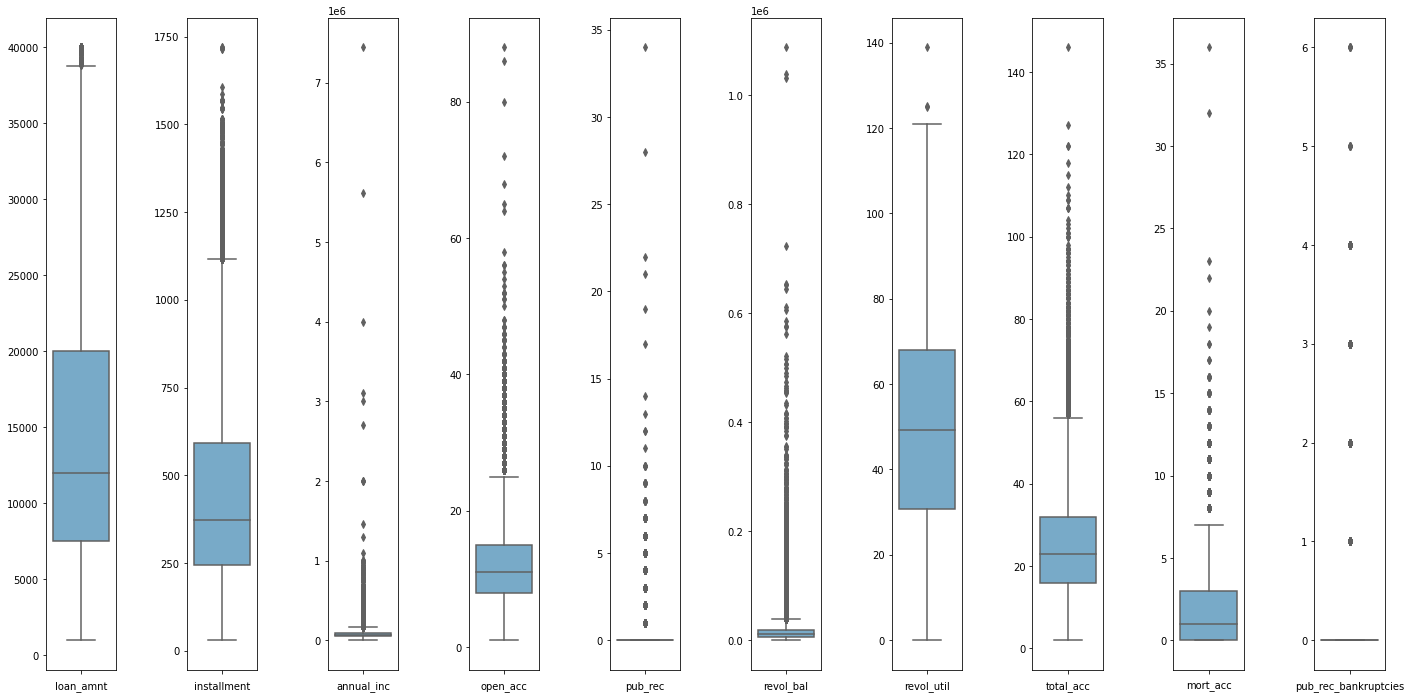

In [339]:
draw_box_plot(df)

# EDA

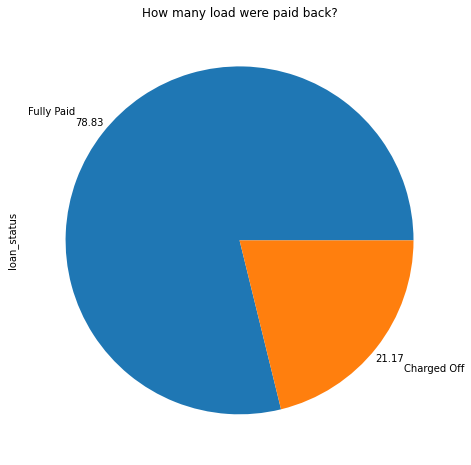

In [340]:
fig = plt.figure(figsize =(8, 8))
df.loan_status.value_counts(normalize=True).plot.pie(autopct='%.2f', 
                                                 pctdistance=1.1, 
                                                 labeldistance=1.2)
plt.title('How many load were paid back?')
plt.show()

## Loan amount 

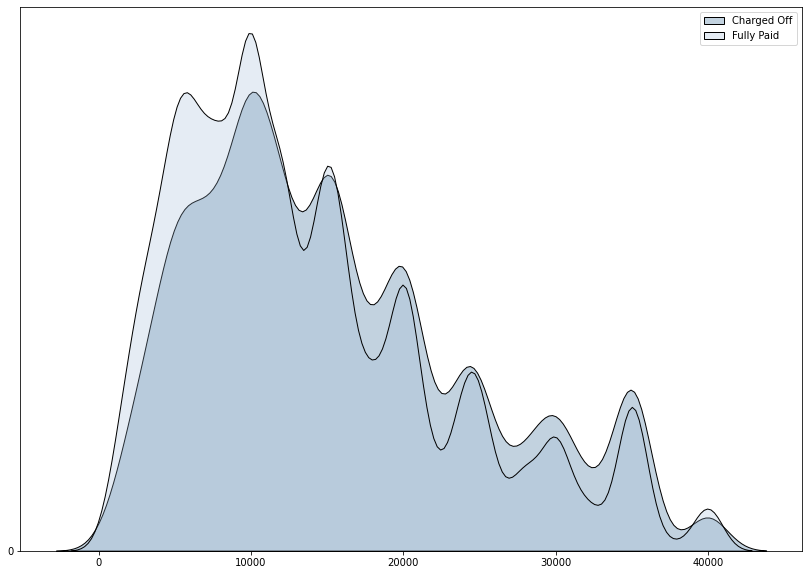

In [341]:
plot_kde('loan_amnt')

Smaller loans tend to be Fully Paid more often

## Loan term

In [342]:
plot_bar(df, 'term')

## Interest rate

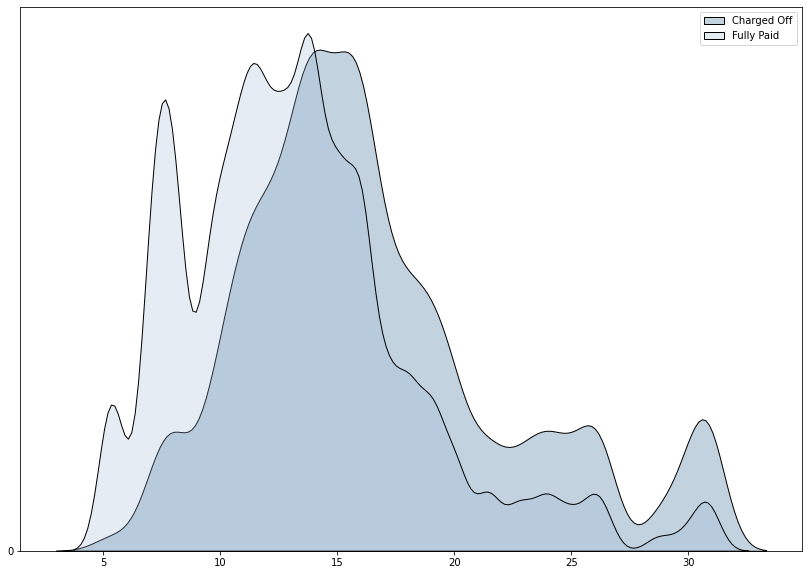

In [343]:
plot_kde('int_rate')

Loans with smaller interest rate tend to be payed more often

## Loan grades

In [344]:
plot_bar(df, 'grade')

The 'larger' the grade of the loan - the bigger the chance of this loan not being payed off. 

## Emplotement lenght

In [345]:
plot_bar(df, 'emp_length')

## Home ownership 

In [346]:
plot_bar(df, 'home_ownership')

## Annual income

In [347]:
bins = (0, 50000, 60000, 70000, 80000, 90000, 100000, 500000, 1000000, 1100000)
labels = ['<50k','<60k', '<70k', '<80k', '<90k', '<100k', '<500k', '<1M', '<11M']
df['level_of_inc'] = pd.cut(x = df['annual_inc'], bins = bins, labels = labels)
df['level_of_inc'].value_counts()

<50k     28151
<500k    20773
<60k     13641
<70k     11841
<80k     10624
<90k      8020
<100k     6823
<1M        114
<11M         2
Name: level_of_inc, dtype: int64

In [348]:
plot_bar(df, 'level_of_inc')

In [349]:
df = df.drop(columns=['level_of_inc'])

## Application type

In [350]:
plot_bar(df, 'application_type')

Interestly enough, those who have taken loan on their own, rather than sharing it, seems to have more success in paying it back. 

Or ... those who took Joint Application already had trouble by taking the loan at the first place

## Purpose

In [351]:
df['purpose'] = df['purpose'].replace({'educational':'other'})
plot_bar(df, 'purpose')

# Feature engeneering: How fast the customer paid back

In [352]:
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'])
df['issue_d']= pd.to_datetime(df['issue_d'])

df['time_paid_back'] = ((df['last_pymnt_d'] - df['issue_d'])/np.timedelta64(1, 'M'))
df = df.drop(columns=['last_pymnt_d', 'issue_d'])

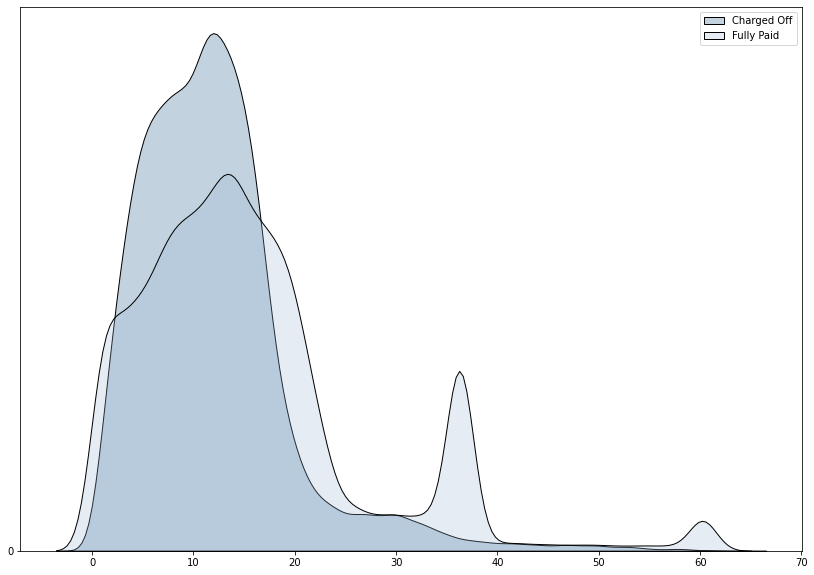

In [353]:
plot_kde('time_paid_back')

## How long customer has a credit account

In [354]:
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'])
df['cr_line'] = ((pd.to_datetime("now") - df['earliest_cr_line'])/np.timedelta64(1, 'Y'))
df = df.drop(columns=['earliest_cr_line'])

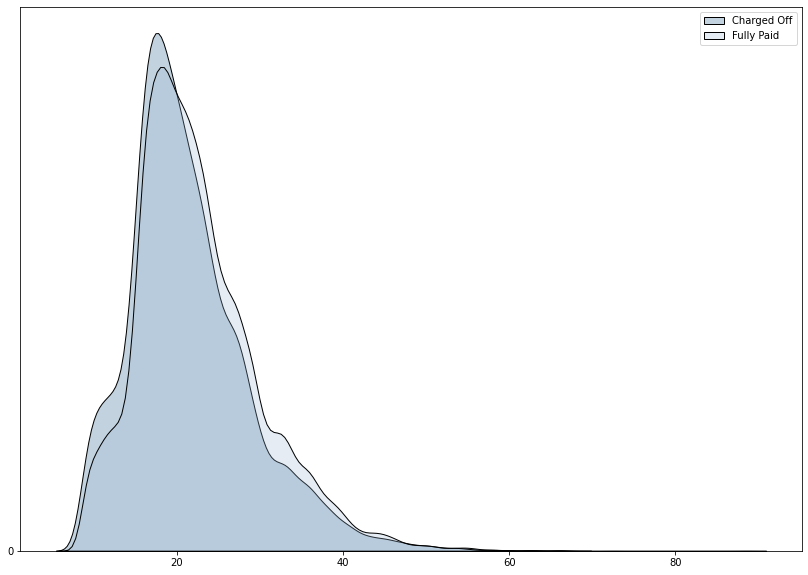

In [355]:
plot_kde('cr_line')

# Mapping

In [356]:
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status,time_paid_back,cr_line
0,30000.0,36 months,8.24,943.42,B,B1,10+ years,OWN,132630.0,Source Verified,...,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off,23.064129,46.863717
1,7200.0,36 months,28.69,300.51,F,F1,10+ years,MORTGAGE,73000.0,Verified,...,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid,11.992033,27.449218
2,7000.0,36 months,11.49,230.80,B,B5,9 years,MORTGAGE,60000.0,Not Verified,...,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid,17.018830,17.699531
3,11200.0,36 months,13.99,382.74,C,C3,3 years,RENT,60000.0,Verified,...,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off,18.037331,18.778266
4,13200.0,36 months,19.99,490.50,D,D4,3 years,RENT,33000.0,Verified,...,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off,10.053595,14.195010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,23575.0,36 months,20.50,882.15,E,E1,10+ years,MORTGAGE,96113.0,Verified,...,116643.0,90.9,21.0,f,Individual,1.0,0.0,Fully Paid,36.008953,42.113448
99996,2000.0,36 months,10.99,65.47,B,B2,< 1 year,MORTGAGE,45000.0,Source Verified,...,1509.0,42.0,33.0,f,Individual,3.0,0.0,Fully Paid,27.959506,27.449218
99997,20000.0,36 months,7.90,625.81,A,A4,10+ years,MORTGAGE,72000.0,Verified,...,31733.0,66.5,36.0,f,Individual,3.0,0.0,Fully Paid,36.008953,30.113201
99998,35000.0,60 months,17.57,880.61,D,D2,7 years,MORTGAGE,120000.0,Verified,...,33503.0,57.7,40.0,w,Individual,6.0,0.0,Fully Paid,27.959506,19.616066


In [357]:
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df.grade = df.grade.map(grade_mapping)

In [358]:
sub_grade_mapping = {'A1': 11, 'A2' : 12, 'A3': 13, 'A4': 14, 'A5': 15,
                     'B1': 21, 'B2' : 22, 'B3': 23, 'B4': 24, 'B5': 25,
                     'C1': 31, 'C2' : 32, 'C3': 33, 'C4': 34, 'C5': 35,
                     'D1': 41, 'D2' : 42, 'D3': 43, 'D4': 44, 'D5': 45,
                     'E1': 51, 'E2' : 52, 'E3': 53, 'E4': 54, 'E5': 55,
                     'F1': 61, 'F2' : 62, 'F3': 63, 'F4': 64, 'F5': 65,
                     'G1': 71, 'G2' : 72, 'G3': 73, 'G4': 74, 'G5': 75}
df.sub_grade = df.sub_grade.map(sub_grade_mapping)

In [359]:
employ_mapping = {'< 1 year': 0, 
                  '1 year': 1,
                  '2 years' : 2,
                  '3 years' : 3,
                  '4 years' : 4,
                  '5 years' : 5,
                  '6 years' : 6,
                  '7 years' : 7,
                  '8 years' : 8,
                  '9 years' : 9,
                  '10+ years' : 10}
df.emp_length = df.emp_length.map(employ_mapping)

In [360]:
loan_status_mapping = {'Charged Off': 0, 
                  'Fully Paid': 1}
df.loan_status = df.loan_status.map(loan_status_mapping)

In [361]:
categ = ['purpose', 'term', 'home_ownership', 'initial_list_status', 'application_type', 'verification_status' ]

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

# Hypotesis testing

A few points were not so clear to me.
* Is there really significant difference between 'Individual' loans and 'Joint Application Loans'? 
* Is employement lenght affecting the final outcome of the loan?



H0 => µ1 = µ2 (population mean of dataset1 is equal to dataset2)

HA => µ1 ≠µ2 (population mean of dataset1 is different from dataset2)


In [365]:
stats.ttest_ind(df['emp_length'][df['loan_status'] == 1],
                df['emp_length'][df['loan_status'] == 0])

Ttest_indResult(statistic=11.255982251040646, pvalue=2.2539711968395243e-29)

In [366]:
stats.ttest_ind(df['application_type'][df['loan_status'] == 1],
                df['application_type'][df['loan_status'] == 0])

Ttest_indResult(statistic=-6.935300707857561, pvalue=4.07805671802054e-12)

In [367]:
stats.ttest_ind(df['cr_line'][df['loan_status'] == 1],
                df['cr_line'][df['loan_status'] == 0])

Ttest_indResult(statistic=18.477911310914823, pvalue=4.166499896732849e-76)

# Correlations

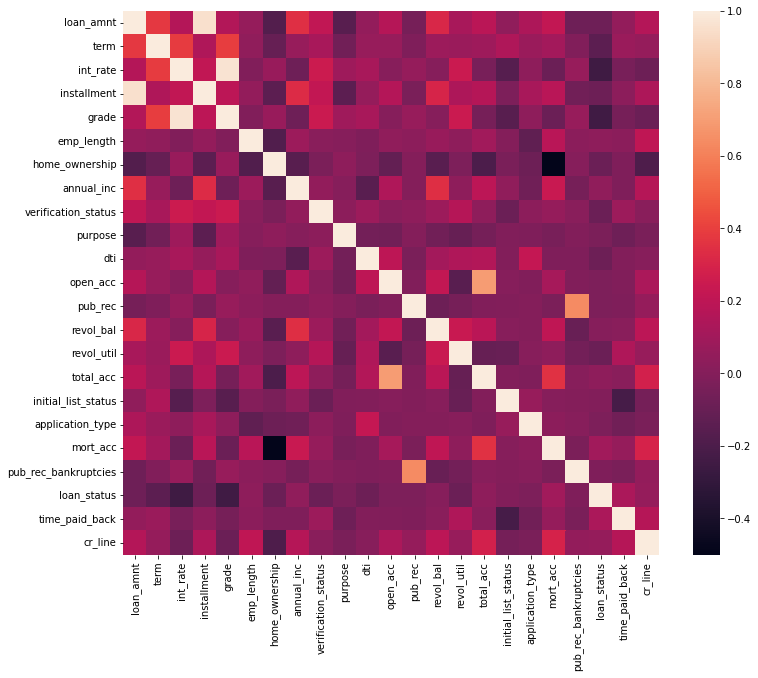

In [368]:
fig = plt.figure(figsize= (12, 10))
corr = df.drop(['sub_grade'], axis=1).corr()
sns.heatmap(corr)
plt.show()

Although there is an indication of a higher correlation in the up left part of the graph when compared to the rest, the highest values were encountered for ProductRelated_Duration x ProductRelated and ExitRates x BounceRates. Therefore, I dropped ProductRelated_Duration and ExitRates from the features list that served as input to the models, and later to the GCP training as well.

In [369]:
corr_matrix = df.corr()
print(corr_matrix["loan_status"].sort_values(ascending=False))

loan_status             1.000000
time_paid_back          0.133312
mort_acc                0.099685
cr_line                 0.058333
annual_inc              0.044163
emp_length              0.035572
total_acc               0.034220
revol_bal               0.004916
initial_list_status    -0.003302
pub_rec_bankruptcies   -0.015468
pub_rec                -0.020628
application_type       -0.021926
open_acc               -0.024971
purpose                -0.027815
loan_amnt              -0.076782
installment            -0.078137
dti                    -0.078911
home_ownership         -0.085299
verification_status    -0.086752
revol_util             -0.088794
term                   -0.138144
grade                  -0.247766
int_rate               -0.250097
sub_grade              -0.252825
Name: loan_status, dtype: float64


In [370]:
corr_matrix = df.corr()
print(corr_matrix["grade"].sort_values(ascending=False))

grade                   1.000000
sub_grade               0.993651
int_rate                0.966002
term                    0.393655
verification_status     0.245969
revol_util              0.244759
installment             0.195989
loan_amnt               0.159269
dti                     0.122329
purpose                 0.095145
home_ownership          0.070033
pub_rec_bankruptcies    0.064274
pub_rec                 0.062851
application_type        0.034467
open_acc                0.009049
revol_bal               0.005680
emp_length             -0.009391
time_paid_back         -0.045442
total_acc              -0.046104
annual_inc             -0.074626
cr_line                -0.087056
mort_acc               -0.089302
initial_list_status    -0.158641
loan_status            -0.247766
Name: grade, dtype: float64


In [371]:
df = df.drop(columns=['int_rate'])

# XGBoost for loan_status prediction

In [372]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [373]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, auc,precision_score
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [374]:
def classification(trial):

  param = {
      "verbosity": 0,  # 0 (silent) - 3 (debug)
      "objective": "binary:logistic",
      "tree_method": "exact",
      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      "subsample": trial.suggest_float("subsample", 0.2, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }

  if param["booster"] in ["gbtree", "dart"]:
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  if param["booster"] == "dart":
    param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  

  model = xgb.XGBClassifier(random_state=42, **param)
  model.fit(X_train_smote,y_train_smote,eval_set=[(X_test,y_test)],verbose=False)

  predicted_values = model.predict(X_test)
  roc_auc_score1= roc_auc_score(y_test, predicted_values)
  return roc_auc_score1

In [389]:
target = df[['loan_status']]
cols = [col for col in df.columns if col not in ['loan_status', 'sub_grade']]
features = df[cols]


X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    stratify = target,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(80000, 21) (20000, 21) (80000, 1) (20000, 1)


In [390]:
smote= SMOTETomek(random_state=42)

X_train_smote,y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape, X_test.shape, y_train_smote.shape, y_test.shape)

(114992, 21) (20000, 21) (114992, 1) (20000, 1)


# Xgboost with OPTUNA hyperparameter tunning 

In [408]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: classification(trial), n_trials= 100)

[I 2022-11-11 15:16:49,559] A new study created in memory with name: no-name-e0b9a14c-6d92-4c53-95d4-f2f2cb56ba3d
[I 2022-11-11 15:16:55,607] Trial 0 finished with value: 0.6297918178933112 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.32479561626896214, 'colsample_bytree': 0.24646688973455957}. Best is trial 0 with value: 0.6297918178933112.
[I 2022-11-11 15:17:05,952] Trial 1 finished with value: 0.5966859465140173 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.8659541126403374, 'colsample_bytree': 0.36987128854262097, 'max_depth': 3, 'min_child_weight': 3, 'eta': 2.716051144654844e-06, 'gamma': 0.00015777981883364995, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6297918178933112.
[I 2022-11-11 15:17:22,195] Trial 2 finished with value: 0.578930700473052 and parameters: {'booster': 'gbtree', 'lambda': 8.528933855762793e-06, 'alpha'

In [409]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.32479561626896214, 'colsample_bytree': 0.24646688973455957}


In [410]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_colsample_bytree,params_eta,params_gamma,params_grow_policy,params_lambda,params_max_depth,params_min_child_weight,params_normalize_type,params_rate_drop,params_sample_type,params_skip_drop,params_subsample,state
0,0,0.629792,2022-11-11 15:16:49.567618,2022-11-11 15:16:55.606879,0 days 00:00:06.039261,1.770717e-07,gblinear,0.246467,NaN,NaN,NaN,6.155564e-04,NaN,NaN,NaN,NaN,NaN,NaN,0.324796,COMPLETE
1,1,0.596686,2022-11-11 15:16:55.611160,2022-11-11 15:17:05.951930,0 days 00:00:10.340770,5.744852e-01,gbtree,0.369871,2.716051e-06,0.000158,depthwise,1.461087e-08,3.0,3.0,NaN,NaN,NaN,NaN,0.865954,COMPLETE
2,2,0.578931,2022-11-11 15:17:05.954217,2022-11-11 15:17:22.195302,0 days 00:00:16.241085,4.452048e-05,gbtree,0.359739,2.352899e-08,0.000725,depthwise,8.528934e-06,7.0,7.0,NaN,NaN,NaN,NaN,0.828141,COMPLETE
3,3,0.629792,2022-11-11 15:17:22.198574,2022-11-11 15:17:26.780263,0 days 00:00:04.581689,6.044730e-08,gblinear,0.552122,NaN,NaN,NaN,2.734703e-06,NaN,NaN,NaN,NaN,NaN,NaN,0.747386,COMPLETE
4,4,0.629792,2022-11-11 15:17:26.783681,2022-11-11 15:17:31.318719,0 days 00:00:04.535038,1.175547e-06,gblinear,0.449369,NaN,NaN,NaN,1.881756e-01,NaN,NaN,NaN,NaN,NaN,NaN,0.730018,COMPLETE


In [411]:
optuna.visualization.plot_optimization_history(study)

In [412]:
optuna.visualization.plot_parallel_coordinate(study)

In [413]:
optuna.visualization.plot_slice(study)

In [414]:
optuna.visualization.plot_param_importances(study)

In [415]:
optuna.visualization.plot_edf(study)

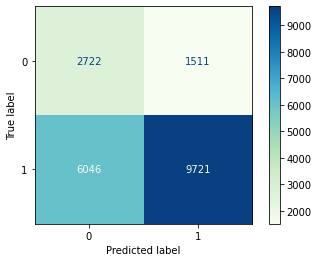

In [416]:
Best_trial = study.best_trial.params
Optuna_XGB_model = XGBClassifier(**Best_trial)
Optuna_XGB_model.fit(X_train_smote, y_train_smote)
optuna_pred = Optuna_XGB_model.predict(X_test)

confusion_matrix = metrics.plot_confusion_matrix(Optuna_XGB_model, X_test, y_test, cmap = 'GnBu')
confusion_matrix

In [417]:
def evaluation(prediction):
  print("\n R-Squared : ", r2_score(y_test, prediction) * 100)
  print('\n ROC AUC Score : ', roc_auc_score(y_test, prediction))
  print("\n Model Accuracy : ",metrics.accuracy_score(y_test, prediction))
  print(classification_report(y_test, prediction))

In [418]:
evaluation(optuna_pred)


 R-Squared :  -126.45508743400362

 ROC AUC Score :  0.6297918178933112

 Model Accuracy :  0.62215
              precision    recall  f1-score   support

           0       0.31      0.64      0.42      4233
           1       0.87      0.62      0.72     15767

    accuracy                           0.62     20000
   macro avg       0.59      0.63      0.57     20000
weighted avg       0.75      0.62      0.66     20000



In [419]:
Optuna_XGB_model.save_model('xgb_model.json')